# Pull images to classify with MakeSense.ai

Randomly pulled, tracked, for use with [MakeSense.ai](https://www.makesense.ai/) as a possible annotation interface.

In [97]:
import config

In [149]:
# where to look for already completed MakeSense annotations
#check_makesense = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations/'
check_makesense = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Annotations_pmcnoncom/MakeSenseAnnotations/'

# where to save new annotations
save_makesense = check_makesense
#save_makesense = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations/test/'

# # which model and weights to use?
# binary_dirs = 'binaries_model11_tfrecordz/'
# weightsFileDir = config.save_weights_dir +'saved_weights/'+'20211216_model11tfz/'
# weightsFile = 'training_1model11_tfrec_model_l0.1890166.h5' # figure/table, fig/table captions

binary_dirs = 'binaries_model7_tfrecordz/'
weightsFileDir = config.save_weights_dir +'saved_weights/'+'20211114_model7tfz/'
weightsFile = 'training_1model7_tfrec_model_l0.020921115.h5' # figure/table, fig/table captions


# how many you wanna grab?
nRandom = 100

# invert colors?
invert_colors = False

In [150]:
# want to use different than the defaults? if not, set to None
ocr_results_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/OCR_processing_pmcnoncom/'
images_jpeg_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_pmcnoncom/RandomSingleFromPDFIndexed/'

In [151]:
# labels for annotations:
labels = ['figure', 'figure caption', 'table', 'math formula', 'sub fig caption', 'colorbar', 'NotSure', 'no label'] # no label is for nothing on the page

In [152]:
import post_processing_utils
from importlib import reload
reload(post_processing_utils)

<module 'post_processing_utils' from '/Users/jillnaiman/figure_and_caption_extraction/post_processing_utils.py'>

In [153]:
import pandas as pd
from glob import glob
import numpy as np
import pickle
import os
import shutil
from PIL import Image

from annotation_utils import get_all_ocr_files, collect_ocr_process_results
from mega_yolo_utils import build_predict
from feature_generation_utils import generate_single_feature
from post_processing_utils import get_ocr_results

In [154]:
if images_jpeg_dir is None: images_jpeg_dir = config.images_jpeg_dir

In [155]:
# save labels
# save feature list
with open(save_makesense +'saved_labels.pickle', 'wb') as ff:
    pickle.dump([labels], ff)   


In [156]:
# get all dones already

# generate donesfile from list
lfiles = glob(check_makesense+'labels*csv')
filenames = []; labelss = []; xmins = []; ymins=[]; xmaxs=[]; ymaxs=[]; widths=[]
fnameSave = []; heights = []
for il,l in enumerate(lfiles):
    d = pd.read_csv(l, names = ['label','xmin','ymin','xmax','ymax', 'fname','x','y'])
    #d = d.drop_duplicates(subset='fname')
    for idd, dd in enumerate(d['fname'].values):
        fn = dd[:dd.rfind('.')+1]
        if fn[-1] == '.': fn = fn[:-1]
        filenames.append(fn)
        fnameSave.append(dd)
    if il == 0:
        dfTmp = d.copy()
    else:
        dfTmp = dfTmp.append(d)
# get unique
fnameSave,uind = np.unique(fnameSave,return_index=True)
# loop and grab
for idd, dd in enumerate(fnameSave):
    mask = dfTmp['fname'] == dd
    labelss.append(dfTmp.loc[mask]['label'].values); xmins.append(dfTmp.loc[mask]['xmin'].values)
    ymins.append(dfTmp.loc[mask]['ymin'].values); 
    # widths and heights!!
    xmaxs.append(dfTmp.loc[mask]['xmax'].values+dfTmp.loc[mask]['xmin'].values); 
    ymaxs.append(dfTmp.loc[mask]['ymax'].values+dfTmp.loc[mask]['ymin'].values)
    widths.append(dfTmp.loc[mask]['x'].values[0]); heights.append(dfTmp.loc[mask]['y'].values[0])
dones = pd.DataFrame({'filename':np.array(filenames)[uind], 'labels':labelss, 'xmin':xmins, 
                      'ymin':ymins, 'xmax':xmaxs,'ymax':ymaxs, 'width':widths, 'height':heights})

In [157]:
dones

,filename,labels,xmin,ymin,xmax,ymax,width,height


In [158]:
donefiles = dones['filename'].values
donefiles
# debug
#donefiles = ['ofx163.1581.PMC5630905_p1.jpeg']

array([], dtype=float64)

In [159]:
ocrFiles = get_all_ocr_files(ocr_results_dir=ocr_results_dir)

In [160]:
print('retreiving OCR data, this can take a moment...')
ws1, paragraphs1, squares1, html1, rotations1,colorbars1 = collect_ocr_process_results(ocrFiles)
# create dataframe
ws, paragraphs, squares, html, rotations,colorbars = [],[],[],[],[],[]
for w,p,s,h,r,c in zip(ws1,paragraphs1, squares1, html1, rotations1,colorbars1):
    if w not in donefiles:
        ws.append(w); paragraphs.append(p);squares.append(s)
        html.append(h); rotations.append(r); colorbars.append(c)
df = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
                   'hocr':html, 'rotation':rotations, 'colorbars':colorbars})#, 'pdfwords':pdfwords})
df = df.drop_duplicates(subset='ws')
df = df.set_index('ws')

retreiving OCR data, this can take a moment...
--- OCR retrieval: on 0 of 3


/Users/jillnaiman/anaconda3/envs/Paper1/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [161]:
if nRandom < len(ws):
    # grab randomly
    ind = np.random.choice(range(len(ws)),nRandom,replace=False)
    #ws = np.array(ws)[ind]
else:
    #ws = np.array(ws)
    ind = np.arange(0,len(ws))

In [162]:
dfout = df.iloc[ind]

In [163]:
dfout.head()

,paragraphs,squares,hocr,rotation,colorbars
ws,,,,,
ofx163.1581.PMC5630905_p1.jpeg,"[(244, 165, 84, 22), (366, 165, 835, 29), (366...","[[[1339, 2361], [2213, 2361], [2213, 2953], [1...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[1559, 3048], [1559, 3084], [1795, 3084], [1..."
10-1055-s-0039-1677738.PMC6382497_p0.jpeg,"[(268, 77, 106, 23), (272, 112, 100, 30), (272...",[],"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[315, 2022], [318, 2069], [618, 2066], [615,..."
SAJC-7-249.PMC6190391_p0.jpeg,"[(156, 182, 2236, 60), (156, 182, 2236, 60), (...","[[[153, 2874], [494, 2874], [494, 3204], [153,...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[161, 2879], [161, 2916], [486, 2916], [486,..."


In [164]:
# ws = dfout.index
# ws
#dfout.index.values.astype('str')

In [165]:
# save label file for annotations
storeTmps = config.tmp_storage_dir + 'MakeSense/'
if not os.path.exists(storeTmps):
    os.mkdir(storeTmps)
# remove, remake
shutil.rmtree(storeTmps)
os.mkdir(storeTmps)

Copy over random images:

In [166]:
# start on empty
if not os.path.exists(storeTmps+'images/'):
    os.makedirs(storeTmps+'images/')
# delete and remake
shutil.rmtree(storeTmps+'images/')
os.makedirs(storeTmps+'images/')

In [167]:
# move files
imgSizes = []; imgSizesOrig = []
for iw,w in enumerate(dfout.index.values.astype('str')):
    #print(w)
    w = images_jpeg_dir + w
    if not invert_colors:
        shutil.copyfile(w, storeTmps+'images/'+ w.split('/')[-1])
        imgSizes.append(Image.open(w).convert('RGB').size)
    else: # invert B/W
        print('not implemented!!')
        import sys; sys.exit()

In [168]:
# write label file
with open(storeTmps + 'labels.txt','w') as f:
    for l in labels:
        f.write(l.replace(' ', '_') + '\n')

For annotations, try to predict with our model:

In [170]:
# get model to run on pages
# read in anchors
# saveFileAnchors = weightsFileDir + 'anchors.pickle'
# with open(saveFileAnchors, 'rb') as f:
#     anchors = pickle.load(f) 
#     anchors = anchors.astype('float32')

    
# feature_dir = config.save_binary_dir + binary_dirs
# # how many features
# with open(feature_dir +'feature_list.pickle', 'rb') as ff:
#     feature_list = pickle.load(ff)[0]
# HACK
feature_list = ['grayscale','fontsize','x_ascenders','x_decenders', 'word confidences', 
                'fraction of numbers in a word','fraction of letters in a word','punctuation', 
                'text angles','Spacy POS']

n_features = len(feature_list)

# labels file for originally trained
LABELS=pd.read_csv(feature_dir + 'LABELS.csv',names=['labels'])['labels'].values.astype('str')

# build the model
weightsFileDownload = weightsFileDir + weightsFile
anchorsFile = weightsFileDir + 'anchors.pickle'  # should this be changed....

model = build_predict(weightsFileDownload, anchorsFile, 
                    feature_dir,LABELS,version=config.version, 
                      debug=False,n_features=n_features)
model.load_weights(weightsFileDownload)

In [171]:
imgSizes

[(2480, 3260), (2555, 3382), (2550, 3300)]

In [172]:
reload(post_processing_utils)
from post_processing_utils import get_ocr_results,get_image_process_boxes, \
    clean_merge_heurstic_captions, clean_overlapping_squares

In [176]:
if not os.path.exists(storeTmps+'annotations/'):
    os.makedirs(storeTmps+'annotations/')
# delete and remake
shutil.rmtree(storeTmps+'annotations/')
os.makedirs(storeTmps+'annotations/')

# save tmp binaries for this
if not os.path.exists(storeTmps+'binaries/'):
    os.makedirs(storeTmps+'binaries/')
# delete and remake
shutil.rmtree(storeTmps+'binaries/')
os.makedirs(storeTmps+'binaries/')

# just for counting
maxboxes = 50 # I think this is actually a place holder...

#for i in range(len(dfout)):
i = 0
if True:
    dfsingle = dfout.iloc[i]
    # if we've made it this far, let's generate features
    img_name, font = generate_single_feature(dfsingle, LABELS, maxboxes, 
                                           feature_list = feature_list, 
                                           binary_dir = storeTmps+'binaries/',
                                                images_jpeg_dir = images_jpeg_dir,
                                                astype='npz', 
                                                 npzcompressed=True) 
    # predict squares in 2 ways
    # 1. MEGA YOLO
    image_np = np.load(img_name)['arr_0']
    image_np = image_np.astype(np.float32) / 255.0 

    boxes, scores, labels = model.predict(image_np[np.newaxis, ...])
    #import sys; sys.exit()
    boxes1, scores1, labels1 = np.squeeze(boxes, 0), np.squeeze(scores, 0), np.squeeze(labels, 0)
    # only non -1 ones
    boxes1 = boxes1[labels1>-1]
    scores1 = scores1[labels1>-1]
    labels1 = labels1[labels1>-1]    
    
    # # post process the thing
    # # get OCR results and parse them, open image for image processing
    # image = 

    backtorgb,image_np,rotatedImage,rotatedAngleOCR,bbox_hocr,\
      bboxes_words,bbsq,cbsq, rotation,bbox_par = get_ocr_results(img_name, None,dfout.iloc[[i]],
                                                                 image_np=image_np,
                                                                 width=imgSizes[i][0], 
                                                                 height=imgSizes[i][1],
                                                                 images_jpeg_dir=images_jpeg_dir)
    # get figures and captions from image processing
    captionText_figcap, bbox_figcap_pars = get_image_process_boxes(backtorgb, 
                                                                   bbox_hocr, 
                                                                   rotatedImage)
    # clean overlapping squares
    # if squares are majorly overlapping, take the one with the highest score
    sboxes_cleaned, slabels_cleaned, sscores_cleaned = clean_overlapping_squares(boxes1,
                                                                                 scores1,
                                                                                 labels1,
                                                                                 img_name)
    # combine figure caption boxes with heuristically found ones
    # -- often the heurstically found boxes are more accurate, especially 
    # in the vertical direction
    boxes_heur, labels_heur, scores_heur,\
      ibbOverlap = clean_merge_heurstic_captions(sboxes_cleaned, 
                                                 slabels_cleaned, 
                                                 sscores_cleaned, 
                                            bbox_figcap_pars, LABELS,None,
                                                width=imgSizes[i][0], 
                                                height=imgSizes[i][1])

    #import sys; sys.exit()
    
            


In [177]:
boxes_heur

array([], dtype=float64)

In [146]:
img_name

'/Users/jillnaiman/Downloads/tmp/MakeSense/binaries/ofx163.1581.PMC5630905_p1.npz'

In [140]:
image_np.shape
import matplotlib.pyplot as plt

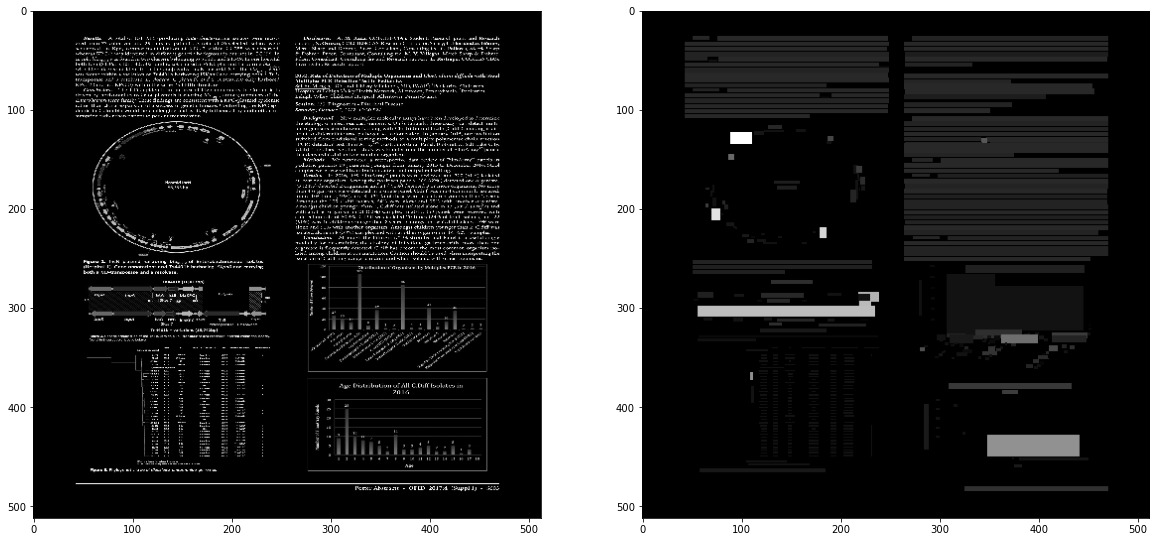

In [179]:
fig, ax = plt.subplots(1,4,figsize=(20,10))
ax[0].imshow(image_np[:,:,0],cmap='gray')
ax[1].imshow(image_np[:,:,1],cmap='gray')
ax[2].imshow(image_np[:,:,1],cmap='gray')
ax[1].imshow(image_np[:,:,1],cmap='gray')

plt.show()

In [178]:
n_features

10

In [137]:
boxes

array([[[-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-1., -1., -1., -1.],
        [-

In [136]:
dfsingle

paragraphs    [(244, 165, 84, 22), (366, 165, 835, 29), (366...
squares       [[[1339, 2361], [2213, 2361], [2213, 2953], [1...
hocr          <?xml version="1.0" encoding="UTF-8"?>\n<!DOCT...
rotation      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
colorbars     [[[1559, 3048], [1559, 3084], [1795, 3084], [1...
Name: ofx163.1581.PMC5630905_p1.jpeg, dtype: object

In [ ]:
if (use_model_ann) and (not redo_makesense) and bad_ann_file is None:
    # should already be in main binaries folder
    for w,imSize in zip(ws,imgSizes):
        fn = w.split('/')[-1]
        fn = fn[:fn.rfind('.')+1]
        if fn[-1] == '.': fn = fn[:-1]
        fn = binariesDir + '../' + fn + '.npz'

        image_np = np.load(fn)['arr_0']
        image_np = image_np.astype(np.float32) / 255.0
        
        boxes, scores, labelsout = model.predict(image_np[np.newaxis, ...])
        boxes, scores, labelsout = np.squeeze(boxes, 0), np.squeeze(scores, 0), np.squeeze(labelsout, 0)
        #print(labelsout)
        # resize boxes
        xfrac = imSize[1]*1.0/IMAGE_W; yfrac = imSize[0]*1.0/IMAGE_H
        if os.path.exists(fn): 
            with open(storeTmps+'annotations/'+ fn.split('/')[-1].split('.npz')[0] + '.txt','w') as fsave:
                for bb,ll in zip(boxes,labelsout):
                    xmin = bb[0]*xfrac; ymin = bb[1]*yfrac; xmax = bb[2]*xfrac; ymax = bb[3]*yfrac
                    x = xmin/imSize[1]; y = ymin/imSize[0]; 
                    w = (xmax-xmin)/imSize[1]; h = (ymax-ymin)/imSize[0]
                    # I think we want centers?
                    x = x+w*0.5; y = y+0.5*h
                    #lab = labels_annotation[int(bb[4])-1]
                    if ll > -1:
                        #lab = LABELS[int(ll)-1]
                        lab = LABELS[int(ll)]
                        #print(ll,lab)
                        if lab == 'multi-figure': lab = 'figure' # rename all to figure for now
                        try: 
                            #l = labels.index(lab)
                            l = labels.index(lab)
                            #print(l)
                        except:
                            l = -1
                        if l > -1: # found in these labels
                            fsave.write(str(l) + ' ' + str(max([x,0])) + ' ' + str(max([y,0])) + ' ' + str(min([w,1])) + ' ' + str(min([h,1])) + '\n')
                        #import sys; sys.exit()
        else:
            print('something has gone wrong')
            import sys; sys.exit()

        #import sys; sys.exit()
        
    #write label file with ALL labels
    with open(storeTmps + 'annotations/' + labelFile,'w') as f:
        for l in labels:
            f.write(l.replace(' ', '_') + '\n')


print('all done!  go classify!')

# ------------ IGNORE BELOW -----------

In [7]:
# add another
#ocrFiles.append('/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/OCR_processing/full_ocr_newPDFs_take2.pickle')

In [8]:
ocrFiles

['/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/OCR_processing_pmcnoncom/full_ocr_newPDFs_TIFF_take1.pickle']

In [9]:
wsout = []
for cp in ocrFiles:
    with open(cp, 'rb') as f:
        wsout1, full_run_squares, full_run_ocr, full_run_rotations, \
             full_run_pdf, full_run_hocr, color_bars,\
              centers_in, centers_out = pickle.load(f) 
    wsout.extend(wsout1)

In [11]:
# take out dones

['/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_pmcnoncom/RandomSingleFromPDFIndexed/ofx163.1581.PMC5630905_p1.jpeg',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_pmcnoncom/RandomSingleFromPDFIndexed/10-1055-s-0039-1677738.PMC6382497_p0.jpeg',
 '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/BenchMarks/Pages_pmcnoncom/RandomSingleFromPDFIndexed/SAJC-7-249.PMC6190391_p0.jpeg']

In [49]:
# do we want to use a model to generate possible annotations for us?
use_model_ann = True # redo, redo_makesense = False must be toggled!
# finally, do we want to use a combo of OTHER pages AND scans from the downloaded PDFs?

# reannotate some bad annoations? -- assume you wanna do this all in one go...
bad_ann_file = None # if none, this is skipped
#bad_ann_file = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations_old/more_bad_ann_redux.csv'

# look for any particular tag?
look_for = None #'table' # set to None for nothing

donesDir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations/' # this is redudent I think...

# want to re-do a whole batch of annotations from a makesense annotations directory?
redo_makesense = False
redo_makesense_folder = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations_orig/'
# what about dones from this?
# new place
redo_makesense_folder_new = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Annotations/MakeSenseAnnotations/'

###########################################################################


# where are scans stored?
images_pulled_dir_orig = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' ## what about Dropbox though????
images_pulled_dir = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/Pages/RandomSingleFromPDFIndexed/' # unskewed, first run

# if we want to copy annotations
annotation_dir = '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_math_ann/'
# what are the YOLO labels?
labels_annotation = ['figure', 'figure caption', 'table', 'table caption', 'math formula', 'colorbar', 'sub fig caption', 'multi-figure']
# what format are the annotations stored in?
IMAGE_H, IMAGE_W = 512, 512

# NOTE: with labels -- only add to END of list for new ones!!!
# where to store the temp files? -- note, this erases what was there!
storeTmps = '/Users/jillnaiman/Downloads/tmpMakeSense/'
# where to store labels?
labelFile = 'labels.txt' # in the storeTmps file

# what labels for annotations?
labels = ['figure', 'figure caption', 'table', 'math formula', 'sub fig caption', 'colorbar', 'NotSure', 'no label'] # no label is for nothing on the page
# used in the already trained model model?
LABELS = ['figure', 'figure caption', 'table']


# how many to do at a time?
nRandom = 100

# invert colors for easier labeling?  Generally false -- hard to see some box boundaries
invert_colors = False

# copy over annotations?
copy_annotations = True

# other important directories
weightsFile = '20210914/training_1_model_orig_training_setsl0.0059608044.h5' # model weights: figure/table, fig/table captions
anchorsFile = '20210914/anchors.pickle'
binariesDir = '/Users/jillnaiman/tmpMegaYolo/binaries/binaries/'
origAnnDir = '/Users/jillnaiman/tmpMegaYolo/binaries/yolo_512x512_cap_ann/'

In [2]:
# update dirs
weightsFile = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/mega_yolo/saved_weights/'+weightsFile
anchorsFile = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/mega_yolo/saved_weights/'+anchorsFile

In [3]:
# OCR results
figCapMain = '/Users/jillnaiman/Dropbox/wwt_image_extraction/FigureLocalization/OCR_processing/'
ocrFilesList = [figCapMain+'full_ocr_results_and_squares_REINDEXED_noOCRskew.pickle',
            figCapMain+'full_ocr_newPDFs_take*.pickle'
           ]

In [4]:
# libraries
import os
import shutil
from glob import glob
import numpy as np
import pandas as pd
import csv
from PIL import Image, ImageOps
import pickle
#import tensorflow as tf
import cv2 as cv

from sys import path
path.append('../../')
from utils import stored_classifications, take_out_dones

import xml.etree.ElementTree as ET
from lxml import etree

# more mega-yolo specific libraries
path.append('./')
from mega_yolo_utils import parse_annotation, build_predict

In [5]:
# write label file
with open(storeTmps + labelFile,'w') as f:
    for l in labels:
        f.write(l.replace(' ', '_') + '\n')
        
if bad_ann_file is not None: redo_makesense = False

In [6]:
#update all OCRfiles
ocrFiles = []
for f in ocrFilesList:
    if '*' not in f:
        ocrFiles.append(f)
    else:
        fs = glob(f)
        for ff in fs:
            ocrFiles.append(ff)
#ocrFiles = ocrFiles2

In [7]:
#ocrFiles

In [8]:
# build the model if we wanna use it!
if use_model_ann and bad_ann_file is None and not redo_makesense:
    model = build_predict(weightsFile, anchorsFile, 
                          binariesDir,LABELS,version='l', debug=False)

Instructions for updating:
Use fn_output_signature instead


In [9]:
#tf.keras.utils.plot_model(model, "yolo_v5.png", show_shapes=True, 
#                                  show_layer_names=True, expand_nested=False)

In [10]:
# if len(pdfLinks.split('classified_')) > 0:
#     ffiles = glob(pdfLinks + '*')
#     ffiles.sort()
#     pdfLinks = ffiles[-1]
# # get PDF links from file
# with open(pdfLinks, 'rb') as f:
#     wsLinks1, dlinks,pages = pickle.load(f)  
# # format for later
# wsLinks = []
# for w in wsLinks1:
#     wsLinks.append(w[:w.rfind('.')].split('/')[-1])

In [11]:
#len(ws), len(paragraphs), len(squares), len(html)
#ws[:10]

In [12]:
# loop and grab hocr
ws = []; paragraphs = []; squares = []; html = []; #pdfwords = []
for cp in ocrFiles:
    # do a little test save here - locations of squares and figure caption boxes
#     try: # mixed numbers of things
#         with open(cp, 'rb') as f:
#             wsout, full_run_squares, full_run_ocr, full_run_rotations, \
#                          full_run_lineNums, full_run_confidences, full_run_paragraphs, \
#                          full_run_links, full_run_gifLinkStorage, full_run_PDFlinkStorage, \
#                          full_run_pageNumStorage, full_run_downloadLinkStorage,\
#                          full_run_htmlText = pickle.load(f)
#    except:
    with open(cp, 'rb') as f:
        #if os.path.getsize(target) > 0
        wsout, full_run_squares, full_run_ocr, full_run_rotations, \
                     full_run_lineNums, full_run_confidences, full_run_paragraphs, \
                     full_run_links, full_run_gifLinkStorage, full_run_PDFlinkStorage, \
                     full_run_pageNumStorage, full_run_downloadLinkStorage,\
                     full_run_htmlText,_,_,_,_ = pickle.load(f)

        # splits
        for i,w in enumerate(wsout):
            wsout[i] = w.split('/')[-1]

        ws.extend(wsout); paragraphs.extend(full_run_paragraphs); squares.extend(full_run_squares);
        html.extend(full_run_htmlText); #pdfwords.extend(full_run_pdfwords)
    #if 'ff74bba9-22fc-4b10-81b1-4f0d706934a6_p15.jpeg' in wsout: print(cp)

df = pd.DataFrame({'ws':ws, 'paragraphs':paragraphs, 'squares':squares, 
                   'hocr':html})#, 'pdfwords':pdfwords})
df = df.drop_duplicates(subset='ws')
df = df.set_index('ws')
dfsave = df.copy()

In [13]:
dfsave

,paragraphs,squares,hocr
ws,,,
1993AJ____105__250G_p8.jpeg,"[(88, 391, 21, 116), (88, 132, 21, 91), (253, ...","[[[192, 380], [2207, 380], [2207, 2917], [192,...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1974ApJ___191__111S_p8.jpeg,"[(88, 133, 21, 74), (88, 254, 22, 53), (2008, ...","[[[485, 280], [2082, 280], [2082, 2596], [485,...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1986AJ_____91__290B_p3.jpeg,"[(256, 84, 222, 32), (256, 84, 222, 32), (88, ...","[[[363, 520], [2255, 520], [2255, 2459], [363,...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1986ApJ___301__346H_p5.jpeg,"[(88, 132, 21, 75), (266, 221, 195, 34), (266,...","[[[731, 330], [2383, 330], [2383, 1920], [731,...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1968ApJ___154L__99K_p2.jpeg,"[(88, 132, 21, 54), (1958, 216, 227, 35), (195...","[[[315, 304], [2198, 304], [2198, 2705], [315,...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
...,...,...,...
1991ApJ___367L__59R_p2.jpeg,"[(88, 131, 21, 56), (228, 250, 189, 33), (228,...",[],"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1993ApJ___417__502H_p9.jpeg,"[(88, 116, 21, 75), (88, 238, 21, 53), (146, 2...",[],"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1938ApJ____88____1B_p0.jpeg,"[(88, 132, 21, 35), (88, 371, 27, 136), (414, ...","[[[408, 1578], [1844, 1578], [1844, 1990], [40...","<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."


In [30]:
# grab dones
if redo_makesense:
    #donesFileMS = 'dones_makesense.csv' # temp storage file
    if os.path.exists(redo_makesense_folder):
        # generate donesfile from list
        lfiles = glob(redo_makesense_folder+'labels*csv')
        filenames = []; labelss = []; xmins = []; ymins=[]; xmaxs=[]; ymaxs=[]; widths=[]
        fnameSave = []; heights = []
        for il,l in enumerate(lfiles):
            d = pd.read_csv(l, names = ['label','xmin','ymin','xmax','ymax', 'fname','x','y'])
            #d = d.drop_duplicates(subset='fname')
            for idd, dd in enumerate(d['fname'].values):
                fn = dd[:dd.rfind('.')+1]
                if fn[-1] == '.': fn = fn[:-1]
                filenames.append(fn)
                fnameSave.append(dd)
            if il == 0:
                dfTmp = d.copy()
            else:
                dfTmp = dfTmp.append(d)
        # get unique
        fnameSave,uind = np.unique(fnameSave,return_index=True)
        # loop and grab
        for idd, dd in enumerate(fnameSave):
            mask = dfTmp['fname'] == dd
            labelss.append(dfTmp.loc[mask]['label'].values); xmins.append(dfTmp.loc[mask]['xmin'].values)
            ymins.append(dfTmp.loc[mask]['ymin'].values); 
            # widths and heights!!
            xmaxs.append(dfTmp.loc[mask]['xmax'].values+dfTmp.loc[mask]['xmin'].values); 
            ymaxs.append(dfTmp.loc[mask]['ymax'].values+dfTmp.loc[mask]['ymin'].values)
            widths.append(dfTmp.loc[mask]['x'].values[0]); heights.append(dfTmp.loc[mask]['y'].values[0])
        dones = pd.DataFrame({'filename':np.array(filenames)[uind], 'labels':labelss, 'xmin':xmins, 
                              'ymin':ymins, 'xmax':xmaxs,'ymax':ymaxs, 'width':widths, 'height':heights})
elif bad_ann_file is not None:
    f = pd.read_csv(bad_ann_file, delimiter = '(')
    ws = []
    for ff in f.index.values:
        ws.append(ff.split('.png')[0])
    dones = pd.DataFrame({'filename':ws})
    
    if os.path.exists(redo_makesense_folder_new):
        # generate donesfile from list
        lfiles = glob(redo_makesense_folder_new+'labels*csv')
        filenames = []; labelss = []; xmins = []; ymins=[]; xmaxs=[]; ymaxs=[]; widths=[]
        fnameSave = []; heights = []
        for il,l in enumerate(lfiles):
            d = pd.read_csv(l, names = ['label','xmin','ymin','xmax','ymax', 'fname','x','y'])
            #d = d.drop_duplicates(subset='fname')
            for idd, dd in enumerate(d['fname'].values):
                fn = dd[:dd.rfind('.')+1]
                if fn[-1] == '.': fn = fn[:-1]
                filenames.append(fn)
                fnameSave.append(dd)
            if il == 0:
                dfTmp = d.copy()
            else:
                dfTmp = dfTmp.append(d)
        # get unique
        fnameSave,uind = np.unique(fnameSave,return_index=True)
        # loop and grab
        for idd, dd in enumerate(fnameSave):
            mask = dfTmp['fname'] == dd
            labelss.append(dfTmp.loc[mask]['label'].values); xmins.append(dfTmp.loc[mask]['xmin'].values)
            ymins.append(dfTmp.loc[mask]['ymin'].values); 
            # widths and heights!!
            xmaxs.append(dfTmp.loc[mask]['xmax'].values+dfTmp.loc[mask]['xmin'].values); 
            ymaxs.append(dfTmp.loc[mask]['ymax'].values+dfTmp.loc[mask]['ymin'].values)
            widths.append(dfTmp.loc[mask]['x'].values[0]); heights.append(dfTmp.loc[mask]['y'].values[0])
        donesMS = pd.DataFrame({'filename':np.array(filenames)[uind], 'labels':labelss, 'xmin':xmins, 
                              'ymin':ymins, 'xmax':xmaxs,'ymax':ymaxs, 'width':widths, 'height':heights})

else: # let's grab a bunch!  Only from the OCR-processed files    
    ws = []
    # loop and grab
    for cp in ocrFiles:
        # do a little test save here - locations of squares and figure caption boxes
        with open(cp, 'rb') as f:
            wsout, full_run_squares, full_run_ocr, full_run_rotations, \
                         full_run_lineNums, full_run_confidences, full_run_paragraphs, \
                        full_run_pdfwords, full_run_pdftextBoxes, \
                         full_run_links, full_run_gifLinkStorage, full_run_PDFlinkStorage, \
                         full_run_pageNumStorage, full_run_downloadLinkStorage, full_run_PDFlayouts,\
                        full_run_htmlTextUS, full_run_htmlText = pickle.load(f)

            # splits
            for i,w in enumerate(wsout):
                wsout[i] = w.split('/')[-1].split('.jpeg')[0]

            ws.extend(wsout)

    dones = pd.DataFrame({'filename':ws})

In [31]:
#len(fnameSave)
#dones

In [32]:
# take out duplicates
dones = dones.drop_duplicates('filename')
dones = dones.reset_index(drop=True)
dones

,filename
0,1993AJ____105__250G_p8
1,1974ApJ___191__111S_p8
2,1986AJ_____91__290B_p3
3,1986ApJ___301__346H_p5
4,1968ApJ___154L__99K_p2
...,...
13254,1991ApJ___367L__59R_p2
13255,1993ApJ___417__502H_p9
13256,1938ApJ____88____1B_p0
13257,1964ApJ___140_1467Z_p9


In [33]:
#dones.iloc[0]
#donesMS

In [34]:
wsOrig = []
for f in dones['filename'].values:
    # check for file
    if os.path.isfile(images_pulled_dir+f+'.jpeg'):
        ff = images_pulled_dir+f+'.jpeg'
    elif os.path.isfile(images_pulled_dir+f+'.jpg'):
        ff = images_pulled_dir+f+'.jpg'
    else:
        # find correct hocr index
        ff = glob(images_pulled_dir+f + '*')
        #if len(ff) == 0: # could be that these aren't re-processed yet
        #    #print('have issue!')
        #    #import sys; sys.exit()
        #else:
        if len(ff) > 0:
            ff = ff[0]
    if len(ff) > 0: # take this out for once everything is re-processed
        wsOrig.append(ff)

In [35]:
#wsOrig
#labels_annotation
#redo_makesense_folder_new
# x = np.array(['sad','sad','bad'])
# np.unique(x)

## Start here for re-running generally

In [36]:
#redo_makesense
#donesDir

In [67]:
# take out dones
if not redo_makesense:
    donesFileMS = 'dones_makesense.csv' # temp storage file
    if os.path.exists(donesDir):
        # generate donesfile from list
        lfiles = glob(donesDir+'labels*csv')
        filenames = []; labelsTotal = []
        for l in lfiles:
            d = pd.read_csv(l, names = ['label','xmin','ymin','xmax','ymax', 'fname','x','y'])
            #d = d.drop_duplicates(subset='fname')
            for dd,ll in zip(d['fname'].values,d['label'].values):
                fn = dd[:dd.rfind('.')+1]
                if fn[-1] == '.': fn = fn[:-1]
                filenames.append(fn)
                labelsTotal.append(ll)
            d = pd.DataFrame({'filename':filenames})
            d = d.drop_duplicates(subset='filename')
            # write donesfile
            #d.to_csv(storeTmps+donesFileMS,index=False)
        filenames = np.unique(filenames)
        wsFull2, _, mask = take_out_dones(wsOrig, filenames, anotherFile = dones['filename'].values) # do we need another file here??
        ws = wsFull2
        # done
        lendone = len(wsOrig)-len(ws)
        print('left to classify:', len(ws), ', already classified = ', lendone)
        # print classes
        for ll in labels:
            numl = np.count_nonzero(np.array(labelsTotal) == ll.replace(' ','_'))
            print('   Total current labels for', ll, '=', numl)
    else:
        ws = wsOrig
else:
    #print('hi')
    ws = wsOrig
    donesFileMS = 'dones_makesense.csv' # temp storage file
    if os.path.exists(redo_makesense_folder_new):
        # generate donesfile from list
        lfiles = glob(redo_makesense_folder_new+'labels*csv')
        filenames = []; labelsTotal = []
        for l in lfiles:
            d = pd.read_csv(l, names = ['label','xmin','ymin','xmax','ymax', 'fname','x','y'])
            #d = d.drop_duplicates(subset='fname')
            for dd in d['fname'].values:
                fn = dd[:dd.rfind('.')+1]
                if fn[-1] == '.': fn = fn[:-1]
                filenames.append(fn)
                labelsTotal.append(d['label'])
            d = pd.DataFrame({'filename':filenames})
            d = d.drop_duplicates(subset='filename')
            # write donesfile
            #filenames = d['fn'].values
            d.to_csv(storeTmps+donesFileMS,index=False)
        #wsFull2, _, mask = take_out_dones(wsOrig, storeTmps+donesFileMS, anotherFile = wsOrig) # do we need another file here??
        wsFull2, _, mask = take_out_dones(wsOrig, filenames, anotherFile = wsOrig) # do we need another file here??
        # delete the storeTmps+donesFileMS for starting over!
        ws = wsFull2
        # done
        lendone = len(wsOrig)-len(ws)
        print('pages left to classify:', len(ws), ', already classified = ', lendone)
    else:
        ws = wsOrig

left to classify: 7669 , already classified =  5590
   Total current labels for figure = 5019
   Total current labels for figure caption = 4854
   Total current labels for table = 682
   Total current labels for math formula = 1041
   Total current labels for sub fig caption = 1412
   Total current labels for colorbar = 531
   Total current labels for NotSure = 7
   Total current labels for no label = 555


In [68]:
##### HERE IS WHERE WE COULD LOOK FOR TABLES SPECIFICALLY ###
#len(wsOrig), len(ws), len(wsFull2)
icountStart = 0 # change if you want to look further down
boxesSave = []; scoresSave = []; labelsSave = []
if look_for is not None:
    ws = []
    icount = icountStart
    while len(ws) < nRandom and icount<len(wsFull2):
        if icount%100 == 0: print('on icount',icount,'of', len(wsFull2), 'len(ws)=',len(ws))
        w = binariesDir + '../'+  wsFull2[icount].split('/')[-1].split('.jpeg')[0]+'.npz'
        image_np = np.load(w)['arr_0']
        image_np = image_np.astype(np.float32) / 255.0
        boxes, scores, labelsout = model.predict(image_np[np.newaxis, ...])
        boxes, scores, labelsout = np.squeeze(boxes, 0), np.squeeze(scores, 0), np.squeeze(labelsout, 0)
        # any tag of a table
        ii = labels.index(look_for)
        if ii in labelsout: ws.append(wsFull2[icount]) # found it!
            
        icount += 1
    
# while len(tables)<X ...


on icount 0 of 7669 len(ws)= 0
on icount 100 of 7669 len(ws)= 0
on icount 200 of 7669 len(ws)= 15
on icount 300 of 7669 len(ws)= 62
on icount 400 of 7669 len(ws)= 99


In [61]:
if look_for is None:
    if nRandom < len(ws):
        # grab randomly
        ind = np.random.choice(range(len(ws)),nRandom,replace=False)
        ws = np.array(ws)[ind]
    else:
        ws = np.array(ws)

In [62]:
#len(ws)

In [63]:
# put in the random directory

# start on empty
if not os.path.exists(storeTmps+'images/'):
    os.makedirs(storeTmps+'images/')
# delete and remake
shutil.rmtree(storeTmps+'images/')
os.makedirs(storeTmps+'images/')

In [64]:
# move files
imgSizes = []; imgSizesOrig = []
for iw,w in enumerate(ws):
    #print(w)
    if not invert_colors:
        shutil.copyfile(w, storeTmps+'images/'+ w.split('/')[-1])
        imgSizes.append(Image.open(w).convert('RGB').size)
    else: # invert B/W
        im = Image.open(w).convert('RGB')
        imgSizes.append(im.size)
        
        if redo_makesense:
            # get orig sizes
            #ff = w.split('/')[-1].split('_p')[0]
            ff = w.split('/')[-1]
            # check for file
            if os.path.isfile(images_pulled_dir_orig+ff):
                indh = ff
            elif os.path.isfile(images_pulled_dir_orig+ff):
                indh = ff
            else:
                # find correct hocr index
                ff = glob(images_pulled_dir_orig+ff.split('.')[0] + '*')
                if len(ff) == 0 or len(ff)>1:
                    print('have issue!')
                    import sys; sys.exit()
                else:
                    indh = ff[0].split('/')[-1]     
            with Image.open(images_pulled_dir_orig+indh).convert('L') as f:
                imgSizesOrig.append(f.size)
        else:
            imgSizesOrig.append(im.size)
        
        im_invert = ImageOps.invert(im)
        imgdata = np.array(im_invert)
        # overplot paragraphs
        plotPar = True
        try:
            dp = dfsave.loc[w.split('/')[-1]]
        except:
            plotPar = False
            #import sys; sys.exit()
            print('no info for:', w)
        #dp = dfsave.loc[w.split('/')[-1]]
        if plotPar:
            hocr = dp['hocr']
            # also, get paragraphs
            # paragraphs from OCR
            bbox_par = []
            nameSpace = ''
            for l in hocr.split('\n'):
                if 'xmlns' in l:
                    nameSpace = l.split('xmlns="')[1].split('"')[0]
                    break
            ns = {'tei': nameSpace}
            tree = etree.fromstring(hocr.encode())
            # get paragraphs
            lines = tree.xpath("//tei:p[@class='ocr_par']/@title", namespaces=ns)
            langs = tree.xpath("//tei:p[@class='ocr_par']/@lang", namespaces=ns)
            for l,la in zip(lines,langs):
                x = l.split(' ')
                b = np.array(x[1:]).astype('int')
                area = (b[3]-b[1])*(b[2]-b[0])
                bbox_par.append((b,area,la))

            fn = w.split('/')[-1]
            fn2 = fn[:fn.rfind('.')+1]
            if fn2[-1] == '.': fn2 = fn2[:-1]
            #fn = w.split('/')[-1].split('_p')[0]
            d = dones.loc[dones['filename'] == fn2]
            widthOrig = imgSizesOrig[iw][0]*1.0; heightOrig = imgSizesOrig[iw][1]*1.0
            width = imgSizes[iw][0]*1.0; height = imgSizes[iw][1]*1.0
            # create fig caption bounding boxs
            boxesOut = []; labelsOut = []; bb = []
            if len(d) > 0 and not use_model_ann: # otherwise skip
                for lab,xmin,ymin,xmax,ymax in zip(d['labels'].values[0], d['xmin'].values[0], 
                                                   d['ymin'].values[0],d['xmax'].values[0],d['ymax'].values[0]):
                    b = [xmin/widthOrig*width,ymin/heightOrig*height,xmax/widthOrig*width,ymax/heightOrig*height]
                    if 'caption' in lab.lower():
                        iouMax = -10; 
                        indIou = []
                        for ibb, bp in enumerate(bbox_par): # these are also xmin,ymin,xmax,ymax -- found w/OCR, original page size
                            bb,aa,ll = bp
                            x1min = b[0]; y1min = b[1]; x1max = b[2]; y1max = b[3]
                            x2min, y2min, x2max, y2max = bb
                            isOverlapping = (x1min <= x2max and x2min <= x1max and y1min <= y2max and y2min <= y1max)
                            if isOverlapping:
                            #if True:
                                coords = np.array(np.round(bb), dtype=np.int32)
                                c1 = (coords[0],coords[1]); c2 = (coords[2], coords[3])
                                cv.rectangle(imgdata, c1, c2, (0, 255, 255), 4)  
            elif use_model_ann and len(d) == 0:
                print('no d!')
                print(fn)

        im_invert = Image.fromarray(imgdata)
        im_invert.save(storeTmps+'images/'+ w.split('/')[-1], quality=100) 
        im.close()

In [65]:
#ff
#d
#copy_annotations

In [66]:
if not os.path.exists(storeTmps+'annotations/'):
    os.makedirs(storeTmps+'annotations/')
# delete and remake
shutil.rmtree(storeTmps+'annotations/')
os.makedirs(storeTmps+'annotations/')

if (copy_annotations) and bad_ann_file is None:
    # copy
    for iw,w in enumerate(ws):
        fn = w.split('/')[-1]
        fn = fn[:fn.rfind('.')+1]
        if fn[-1] == '.': fn = fn[:-1]
        fn = annotation_dir + fn + '.xml'
        # open and parse -- ASSUMES LABELS ARE AS LISTED
        #labels_annotation
        if os.path.exists(fn): 
            img_name, bbox = parse_annotation([fn],labels_annotation) 
            # bbox is in xmin, ymin, xmax,ymax
            xfrac = imgSizes[iw][1]*1.0/IMAGE_W; yfrac = imgSizes[iw][0]*1.0/IMAGE_H
            with open(storeTmps+'annotations/'+ fn.split('/')[-1].split('.xml')[0] + '.txt','w') as fsave:
                if len(bbox) > 0:
                    for bb in bbox[0]:
                        xmin = bb[0]*xfrac; ymin = bb[1]*yfrac; xmax = bb[2]*xfrac; ymax = bb[3]*yfrac
                        #x = int(round(xmin/imgSizes[iw][1])); y = int(round(ymin/imgSizes[iw][0])); 
                        #w = int(round((xmax-xmin)/imgSizes[iw][1])); h = int(round((ymax-ymin)/imgSizes[iw][0]))
                        x = xmin/imgSizes[iw][1]; y = ymin/imgSizes[iw][0]; 
                        w = (xmax-xmin)/imgSizes[iw][1]; h = (ymax-ymin)/imgSizes[iw][0]
                        # I think we want centers?
                        x = x+w*0.5; y = y+0.5*h
                        lab = labels_annotation[int(bb[4])-1]
                        if lab == 'multi-figure': lab = 'figure' # rename all to figure for now
                        try: 
                            l = labels.index(lab)
                        except:
                            l = -1
                        if l > -1: # found in these labels
                            fsave.write(str(l) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n')
            
    #write label file
    with open(storeTmps + 'annotations/' + labelFile,'w') as f:
        for l in labels:
            f.write(l.replace(' ', '_') + '\n')

elif bad_ann_file is not None:
    for iw,w in enumerate(ws):
        fn = w.split('/')[-1]
        fn = fn[:fn.rfind('.')+1]
        if fn[-1] == '.': fn = fn[:-1]
        fn = annotation_dir + fn + '.xml'
        # open and parse -- ASSUMES LABELS ARE AS LISTED
        #labels_annotation
        if os.path.exists(fn): 
            img_name, bbox = parse_annotation([fn],labels_annotation) 
            # bbox is in xmin, ymin, xmax,ymax
            xfrac = imgSizes[iw][1]*1.0/IMAGE_W; yfrac = imgSizes[iw][0]*1.0/IMAGE_H
            with open(storeTmps+'annotations/'+ fn.split('/')[-1].split('.xml')[0] + '.txt','w') as fsave:
                if len(bbox) > 0:
                    for bb in bbox[0]:
                        xmin = bb[0]*xfrac; ymin = bb[1]*yfrac; xmax = bb[2]*xfrac; ymax = bb[3]*yfrac
                        #x = int(round(xmin/imgSizes[iw][1])); y = int(round(ymin/imgSizes[iw][0])); 
                        #w = int(round((xmax-xmin)/imgSizes[iw][1])); h = int(round((ymax-ymin)/imgSizes[iw][0]))
                        x = xmin/imgSizes[iw][1]; y = ymin/imgSizes[iw][0]; 
                        w = (xmax-xmin)/imgSizes[iw][1]; h = (ymax-ymin)/imgSizes[iw][0]
                        # I think we want centers?
                        x = x+w*0.5; y = y+0.5*h
                        lab = labels_annotation[int(bb[4])-1]
                        if lab == 'multi-figure': lab = 'figure' # rename all to figure for now
                        try: 
                            l = labels.index(lab)
                        except:
                            l = -1
                        if l > -1: # found in these labels
                            fsave.write(str(l) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + '\n')
                # other ones
                dMS = donesMS.loc[donesMS['filename']==fn.split('/')[-1].split('.xml')[0]]
                ww,hh = dMS['width'].values,dMS['height'].values
                for ls,xmins,xmaxs,ymins,ymaxs in zip(dMS['labels'].values, 
                                                            dMS['xmin'].values,
                                                            dMS['xmax'].values,dMS['ymin'].values,
                                                            dMS['ymax'].values):
                    for l,xmin,xmax,ymin,ymax in zip(ls,xmins,xmaxs,ymins,ymaxs):
                        if 'figure' != l and 'figure_caption' != l and 'table' != l:
                            w = xmax-xmin; h = ymax-ymin
                            fsave.write(str(labels.index(l.replace('_',' '))) + ' ' + \
                                        str((xmin+0.5*w)/ww[0]) + ' ' + str((ymin+0.5*h)/hh[0]) + ' ' + str(w/ww[0]) + ' ' + str(h/hh[0]) + '\n')
                    
                #import sys; sys.exit()
            
    #write label file
    with open(storeTmps + 'annotations/' + labelFile,'w') as f:
        for l in labels:
            f.write(l.replace(' ', '_') + '\n')

elif redo_makesense: # grab old annotations
    for iw, ww in enumerate(ws):
        if '_p' in ww:
            fn = ww.split('/')[-1]
            fn2 = fn[:fn.rfind('.')+1]
            if fn2[-1] == '.': fn2 = fn2[:-1]
            #fn = ww.split('/')[-1].split('_p')[0]

            d = dones.loc[dones['filename'] == fn2]
            w = d['width'].values[0]*1.0; h = d['height'].values[0]*1.0
            #w = imgSizesOrig[iw][0]*1.0; h = imgSizesOrig[iw][1]*1.0
            
            # check ratios -- scanned pages can be subsets of full PDFs
            rDPI = imgSizes[iw][0]/imgSizes[iw][1]; rImg = imgSizesOrig[iw][0]/imgSizesOrig[iw][1]
            if rDPI == rImg:
                xc = 0
            else: # we have a border that has been cut and need to re-size
                dX = rDPI*imgSizesOrig[iw][1] # dX1/dY1 * dY2
                xc = (dX-imgSizesOrig[iw][0])*0.5
            
            #if xc != 0: import sys; sys.exit()
            # for translation
            fracy = imgSizes[iw][1]*1.0/imgSizesOrig[iw][1]
            with open(storeTmps+'annotations/'+ fn2 + '.txt','w') as fsave:
                for lab,xmin,ymin,xmax,ymax in zip(d['labels'].values[0], d['xmin'].values[0], 
                                                   d['ymin'].values[0],d['xmax'].values[0],d['ymax'].values[0]):
                #for lab,(xmin,ymin,xmax,ymax) in zip(labelsOut,boxesOut):
                    try: 
                        l = labels.index(lab.replace('_',' '))
                    except:
                        l = -1
                    if l > -1: # found in these labels
                        #x = xmin + 0.5*(xmax-xmin); y = ymin + 0.5*(ymax-ymin)
                        #fsave.write(str(l) + ' ' + str(x/w) + ' ' + str(y/h) + \
                        #            ' ' + str((xmax-xmin)/w) + ' ' + str((ymax-ymin)/h) + '\n')
                        if abs(fracy-1.0) < 0.05:
                            x1 = (xmin+xc)/fracy; y1 = ymin*fracy; x2 = (xmax-xc)*fracy; y2 = ymax*fracy
                            xc1 = x1 + 0.5*(x2-x1); yc1 = y1 + 0.5*(y2-y1)
                            if x1>0 and (x2-x1)> 0:
                                fsave.write(str(l) + ' ' + str(xc1/w) + ' ' + str(min([yc1/h,1.0])) + \
                                        ' ' + str(min([(x2-x1)/w,1.0-x1/w])) + ' ' + str(min([(y2-y1)/h,1.0-y1/h])) + '\n')
                        else:
                            xc1 = xmin + 0.5*(xmax-xmin); yc1 = ymin + 0.5*(ymax-ymin)
                            fsave.write(str(l) + ' ' + str(xc1/w) + ' ' + str(min([yc1/h,1.0])) + \
                                        ' ' + str(min([(xmax-xmin)/w,1.0])) + ' ' + str(min([(ymax-ymin)/h,1.0])) + '\n')
                            

        else:
            print('nope for', ww)
            
    #write label file
    with open(storeTmps + 'annotations/' + labelFile,'w') as f:
        for l in labels:
            f.write(l.replace(' ', '_') + '\n')    
    
            
if (use_model_ann) and (not redo_makesense) and bad_ann_file is None:
    # should already be in main binaries folder
    for w,imSize in zip(ws,imgSizes):
        fn = w.split('/')[-1]
        fn = fn[:fn.rfind('.')+1]
        if fn[-1] == '.': fn = fn[:-1]
        fn = binariesDir + '../' + fn + '.npz'

        image_np = np.load(fn)['arr_0']
        image_np = image_np.astype(np.float32) / 255.0
        
        boxes, scores, labelsout = model.predict(image_np[np.newaxis, ...])
        boxes, scores, labelsout = np.squeeze(boxes, 0), np.squeeze(scores, 0), np.squeeze(labelsout, 0)
        #print(labelsout)
        # resize boxes
        xfrac = imSize[1]*1.0/IMAGE_W; yfrac = imSize[0]*1.0/IMAGE_H
        if os.path.exists(fn): 
            with open(storeTmps+'annotations/'+ fn.split('/')[-1].split('.npz')[0] + '.txt','w') as fsave:
                for bb,ll in zip(boxes,labelsout):
                    xmin = bb[0]*xfrac; ymin = bb[1]*yfrac; xmax = bb[2]*xfrac; ymax = bb[3]*yfrac
                    x = xmin/imSize[1]; y = ymin/imSize[0]; 
                    w = (xmax-xmin)/imSize[1]; h = (ymax-ymin)/imSize[0]
                    # I think we want centers?
                    x = x+w*0.5; y = y+0.5*h
                    #lab = labels_annotation[int(bb[4])-1]
                    if ll > -1:
                        #lab = LABELS[int(ll)-1]
                        lab = LABELS[int(ll)]
                        #print(ll,lab)
                        if lab == 'multi-figure': lab = 'figure' # rename all to figure for now
                        try: 
                            #l = labels.index(lab)
                            l = labels.index(lab)
                            #print(l)
                        except:
                            l = -1
                        if l > -1: # found in these labels
                            fsave.write(str(l) + ' ' + str(max([x,0])) + ' ' + str(max([y,0])) + ' ' + str(min([w,1])) + ' ' + str(min([h,1])) + '\n')
                        #import sys; sys.exit()
        else:
            print('something has gone wrong')
            import sys; sys.exit()

        #import sys; sys.exit()
        
    #write label file with ALL labels
    with open(storeTmps + 'annotations/' + labelFile,'w') as f:
        for l in labels:
            f.write(l.replace(' ', '_') + '\n')


print('all done!  go classify!')

all done!  go classify!
